**Set AFLW2000 dataset**

import module and packages

In [4]:
import os

from scipy.io import loadmat
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import pandas as pd

read mat format

In [5]:
dir = "/data/komedi/AFLW/AFLW2000/"
image_list = sorted([os.path.join(dir,file) for file in os.listdir(dir) if file.endswith('jpg')])
label_list = sorted([os.path.join(dir,file) for file in os.listdir(dir) if file.endswith('mat')])
"""
2,000 number of file
"""

'\n2,000 number of file\n'

get image name 

In [6]:
margin = 200
# AFLW는 face crop된 상태로 시작하기에 이미지 크기 확장, 즉 image=crop_img, crop_img=image
csv_lists = []
start_num = 0
max_num = start_num+500

cnt = 0

os.makedirs(f"/data/komedi/AFLW/{max_num}/images_{max_num}",exist_ok=True)
os.makedirs(f"/data/komedi/AFLW/{max_num}/cropimg_{max_num}",exist_ok=True)
for _, num in enumerate(tqdm(range(start_num, len(image_list)))):
    # if cnt >= 1:
    #     break
    if num>=max_num:
        break
    csv_list = []
    
    image = Image.open(image_list[num])
    w, h = image.size
    extract_area = (-margin//2,
                 -margin//2,
                 w+margin//2,
                 h+margin//2)
    extract_img = image.crop(extract_area)

    image_name = Path(image_list[num]).stem

    image.save(f"/data/komedi/AFLW/{max_num}/cropimg_{max_num}/{image_name}.jpg")
    extract_img.save(f"/data/komedi/AFLW/{max_num}/images_{max_num}/{image_name}.jpg")

    csv_list.append(f"{image_name}.jpg")
    csv_list.append(f"/data/komedi/AFLW/{max_num}/images_{max_num}/{image_name}.jpg")
    for n in (200,200,450,450):
        csv_list.append(n)

    label = loadmat(label_list[num])
    
    list_x =label['pt3d_68'][0,:]
    list_y =label['pt3d_68'][1,:]

    for i in range(len(list_x)):
        csv_list.append((list_x[i],list_y[i]))

    csv_lists.append(csv_list)

    df = pd.DataFrame(csv_lists, index=None)
    df.to_csv(f"/data/komedi/AFLW/{max_num}/aflw_68pt_anno_{max_num}.csv",header=None, index=None)

    cnt+=1

 25%|██▌       | 500/2000 [00:35<01:46, 14.10it/s]


load 68pt annotation csv file

In [7]:
max_num

500

In [8]:
df_lists = pd.read_csv(f"/data/komedi/AFLW/{max_num}/aflw_68pt_anno_{max_num}.csv", header=None).values.tolist()
"""
idx 0: file name
idx 1: file path
idx 2 ~ 5: bbox(left, top, width, height)
idx 6 ~ : landmark
"""
len(df_lists[0]) # 74 okay

74

set sorted list

In [9]:
# 18 point sort

IDX_LIST = {
    "1":27, # soft_tissue_nasion        -1
    "2":39, # right_inner_canthus     -2
    "3":42, # left_inner_canthus      -2
    "4":36, # right_outer_canthus     -3
    "5":45, # left_outer_canthus      -3
    "6":2, # right_zygomatic_width    -4
    "7":14, # left_zygomatic_width    -4
    "8":28, # mid_dorsum                -5
    "9":30, # nasal_tip                 -6
    "10":33, # subnasale                 -8
    "11":51, # philtral_tubercle        -10
    "12":48, # right_outer_commissure -11
    "13":54, # left_outer_commissure  -11
    "14":5, # right_gonial_width      -12
    "15":11, # left_gonial_width      -12
    "16":8, # mid_symphysis             -14
    "17":62, # lib_junction             -17
    "19":57
}

# 2 point to sort

def calculatelandmark(point1, point2):
    (x1,y1) = point1
    (x2,y2) = point2
    return (x1+x2)//2, (y1+y2)//2

In [12]:
# sort 68pt to 20pt
idx = 0
landmarks_list = []
for _, idx in enumerate(tqdm(range(len(df_lists)))):
    # if idx>=1:
    #     break
    landmarks = []
    cal = []

    margin = 200
    bbox = (int(df_lists[idx][2]),
            int(df_lists[idx][3]),
            int(df_lists[idx][4])+100,
            int(df_lists[idx][5])+100
    )

    image = Image.open(df_lists[idx][1])
    crop_image = image.crop(bbox)

    # plt.figure(figsize=(22,22))
    # plt.imshow(crop_image)

    landmarks.append(df_lists[idx][0]) # append image name
    landmarks.append("AFLW")
    landmarks.append("S0")
    landmarks.append(df_lists[idx][1]) # append image path

    # bbox process
    box = []
    for i in range(len(bbox)):
        landmarks.append(bbox[i])

    for idx, landmark in enumerate(df_lists[idx][6:]):
        if idx in list(IDX_LIST.values()):
            x,y = eval(landmark[1:-1])
            # plt.scatter(x, y)
            # plt.annotate(idx, (x, y))
            landmarks.append((int(x),int(y))) # append auto landmarks
        if idx in (21,22,33,51):
            x,y = eval(landmark[1:-1])
            cal.append((x,y)) 
    landmarks.append(calculatelandmark(cal[0],cal[1])) # append calculate landmark
    landmarks.append(calculatelandmark(cal[2],cal[3])) # append calculate landmark
    # x_2, y_2 = calculatelandmark(cal[0],cal[1])
    # plt.scatter(x_2, y_2)
    # x_3,y_3 = calculatelandmark(cal[2],cal[3])
    # plt.scatter(x_3, y_3)
    landmarks_list.append(landmarks)
len(landmarks_list[0]) # 28 okay

100%|██████████| 500/500 [00:01<00:00, 260.83it/s]


28

assemble 20pt and 7pt

In [14]:
max_num

500

In [27]:
manual_anno = pd.read_csv(f"/data/komedi/AFLW/{max_num}/alfw_7pt_anno_{max_num}.csv").values.tolist()
sort_manual = []
for manual in manual_anno:
    if manual[3] == 7:
        sort_manual.append(manual)
len(sort_manual)/7

469.0

In [28]:
# assemble
assemble_list = []
for landmark in landmarks_list:
    for manual in sort_manual:
        if landmark[0]==manual[0]:
            x,y = eval(manual[5])["cx"], eval(manual[5])["cy"]
            landmark.append((x,y))
    assemble_list.append(landmark) # 35 x number of images
len(assemble_list[0]) # if 35, OK

42

In [20]:
len(assemble_list)

500

sort not manual annotated file

In [21]:
# sort not manual annotate
finale_list = []
for assemble in assemble_list:
    if len(assemble)==35:
        finale_list.append(assemble)
len(finale_list)

469

save dataframe

In [22]:
# dataframe and save
df = pd.DataFrame(finale_list)
df.to_csv(f"/data/komedi/AFLW/{max_num}/assemble_{max_num}.csv",header=None, index=None)

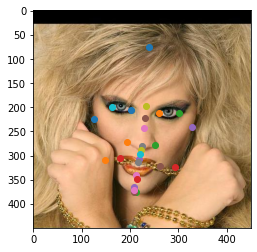

In [26]:
# check matching
image = Image.open(finale_list[0][3])
crop_image = image.crop((200-100,200-100,450+100,450+100))
for idx, landmark in enumerate(finale_list[0][8:]):
    x,y = landmark
    plt.scatter(x,y)
plt.imshow(crop_image)

finalize check

In [48]:
list_ = pd.read_csv("/data/komedi/AFLW/500/assemble_500.csv",header=None).values.tolist()

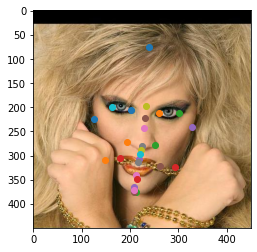

In [50]:
image = Image.open(list_[0][3])
margin = 200
image_crop = image.crop((list_[0][4]-margin//2,
                         list_[0][5]-margin//2,
                         list_[0][6]+margin//2,
                         list_[0][7]+margin//2))
for point in list_[0][8:]:
    point = point[1:-1]
    x,y = eval(point)
    plt.scatter(x,y)
plt.imshow(image_crop)